# Step 1: Offline Baseline – Isolation Forest

In this notebook, we apply the Isolation Forest algorithm to the time series datasets generated earlier (Normality 1–3) in a fully offline setting. The full dataset is provided to the model at once, simulating scenarios without real-time constraints.

We use synthetic labels for evaluation and measure the model’s precision, recall, and F1-score.


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# Set paths
DATASET_PATH = "generated_datasets"
PLOTS_PATH = "results_offline_iforest"
RESULTS_CSV = "offline_iforest_results.csv"
CONTAMINATION = 0.05  # Assumed anomaly rate

# Create output folder if it doesn't exist
os.makedirs(PLOTS_PATH, exist_ok=True)

## Load Datasets

We iterate through all `.npy` files (excluding `_boundaries.npy`) in the `generated_datasets/` folder. Each dataset contains a normalized, concatenated time series.


In [23]:
def load_dataset(file):
    """Loads the time series data from a .npy file"""
    return np.load(os.path.join(DATASET_PATH, file))

## Generate Synthetic Anomaly Labels

Because we do not yet have true ground truth labels, we simulate them by assuming that the last 5% of the data points are anomalous.


In [24]:
def generate_synthetic_labels(length, contamination=CONTAMINATION):
    """Simulate labels by assuming the last X% of points are anomalies"""
    n_anomalies = int(length * contamination)
    labels = np.zeros(length)
    labels[-n_anomalies:] = 1  # anomalies at the end
    return labels


## Run Isolation Forest

We fit the Isolation Forest model on the full dataset and evaluate its performance using synthetic labels.


In [25]:
def run_isolation_forest(data, contamination=CONTAMINATION):
    """Applies Isolation Forest and returns predictions + anomaly scores"""
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(data)
    scores = model.decision_function(data)  # Higher = more normal
    preds = model.predict(data)
    preds_binary = np.where(preds == -1, 1, 0)  # Convert to 1=anomaly
    return preds_binary, scores


In [29]:
def evaluate(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, -scores) if scores is not None else None  # Invert scores if higher = more normal
    return precision, recall, f1, auc

def plot_results(data, scores, preds, title, save_path,show=True):
    data = data.flatten()
    plt.figure(figsize=(14, 5))
    plt.plot(data, label="Time Series", alpha=0.6)
    plt.plot(scores, label="Anomaly Score", color='orange', linewidth=1)
    anomalies = np.where(preds == 1)[0]
    plt.scatter(anomalies, data[anomalies], color='red', label="Anomaly", zorder=3)
    plt.title(title)
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close()


## Run Model on All Datasets

We now process every Normality dataset (excluding the `_boundaries.npy` files), run the model, evaluate, and save a plot and performance metrics.


Processing: normality_1_daphnet.npy


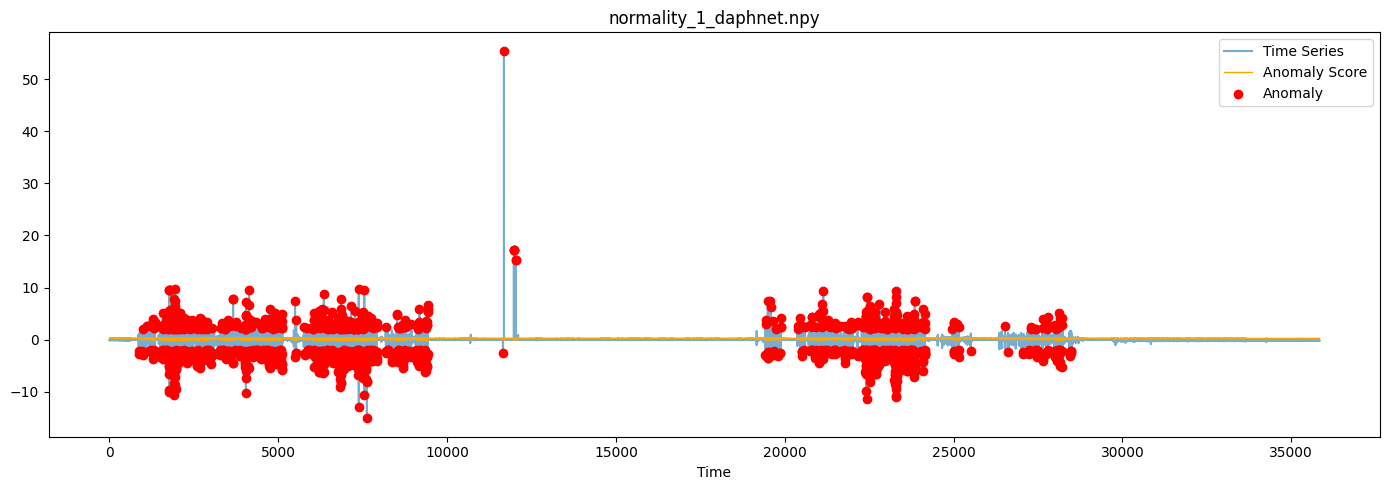

Processing: normality_1_genesis.npy


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


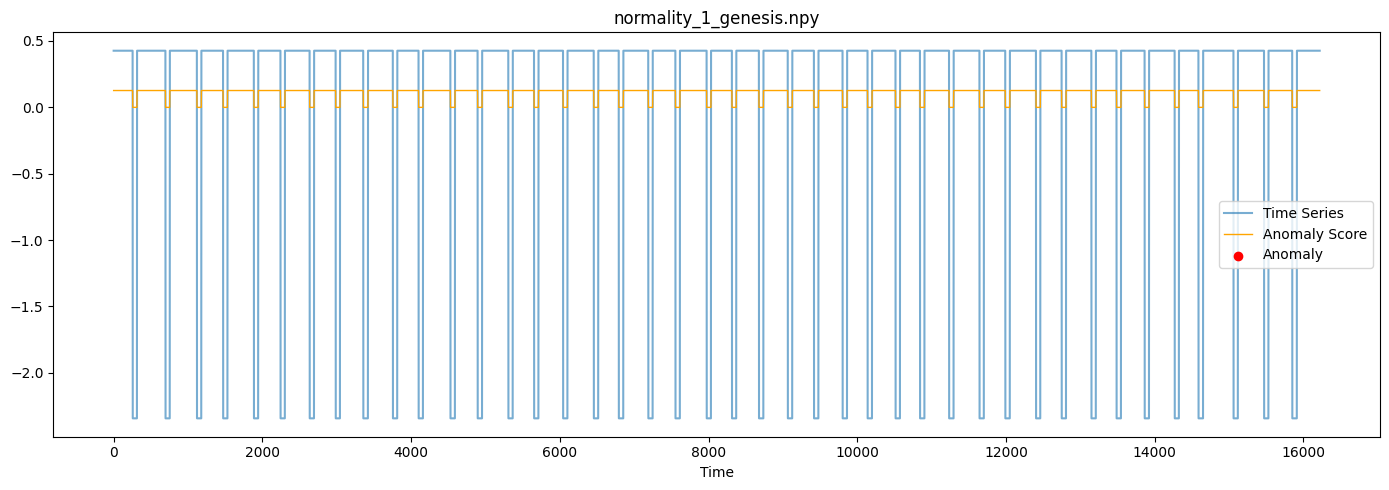

Processing: normality_1_nasa-msl.npy


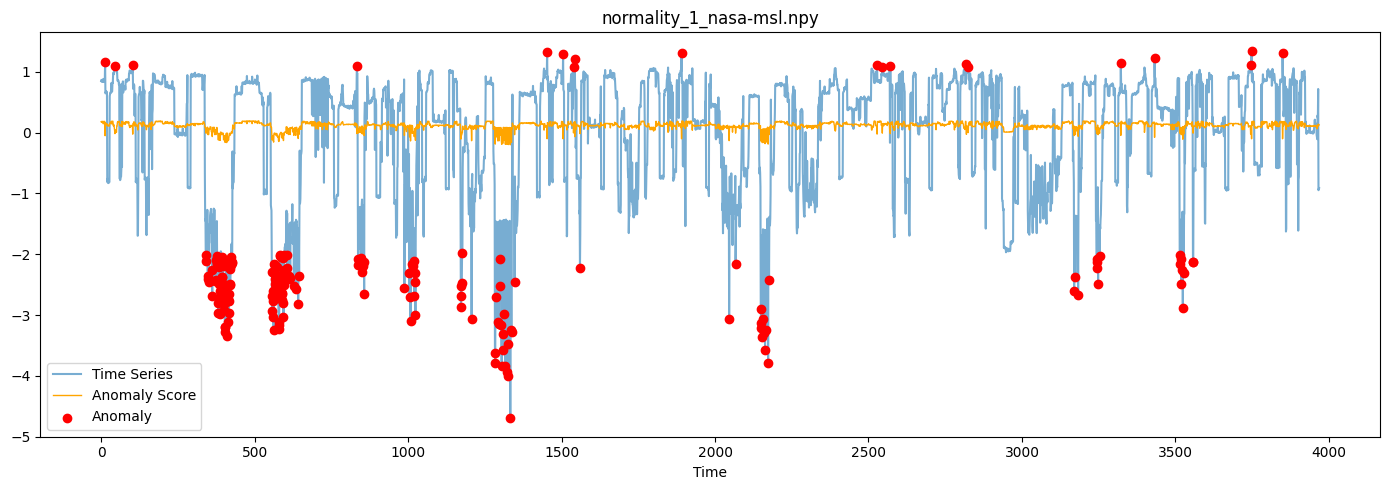

Processing: normality_2_1_daphnet_genesis.npy


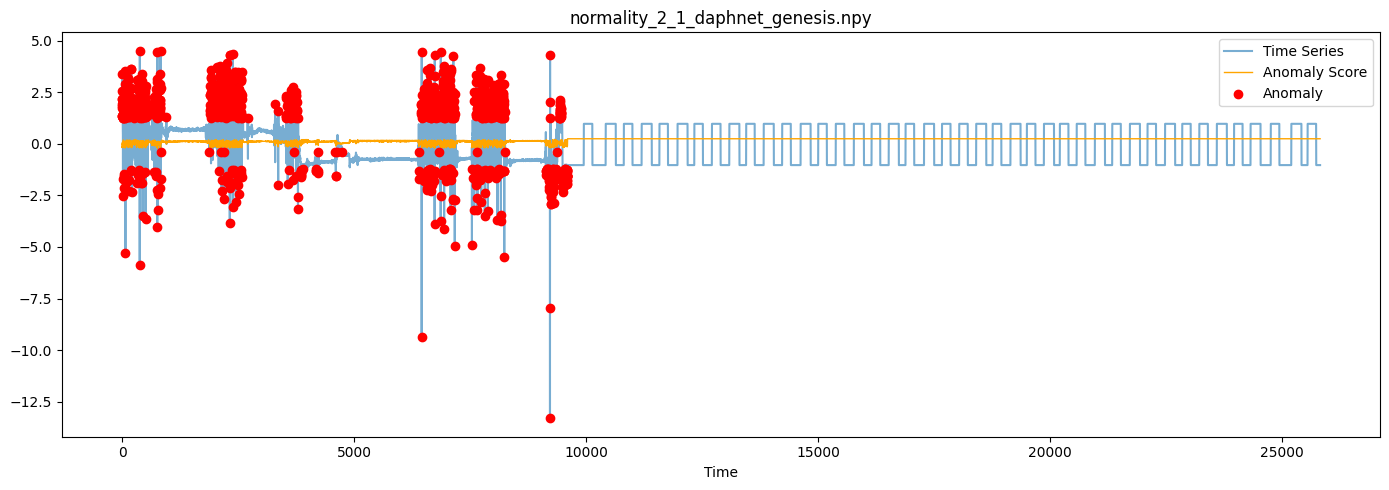

Processing: normality_2_2_daphnet_nasa-msl.npy


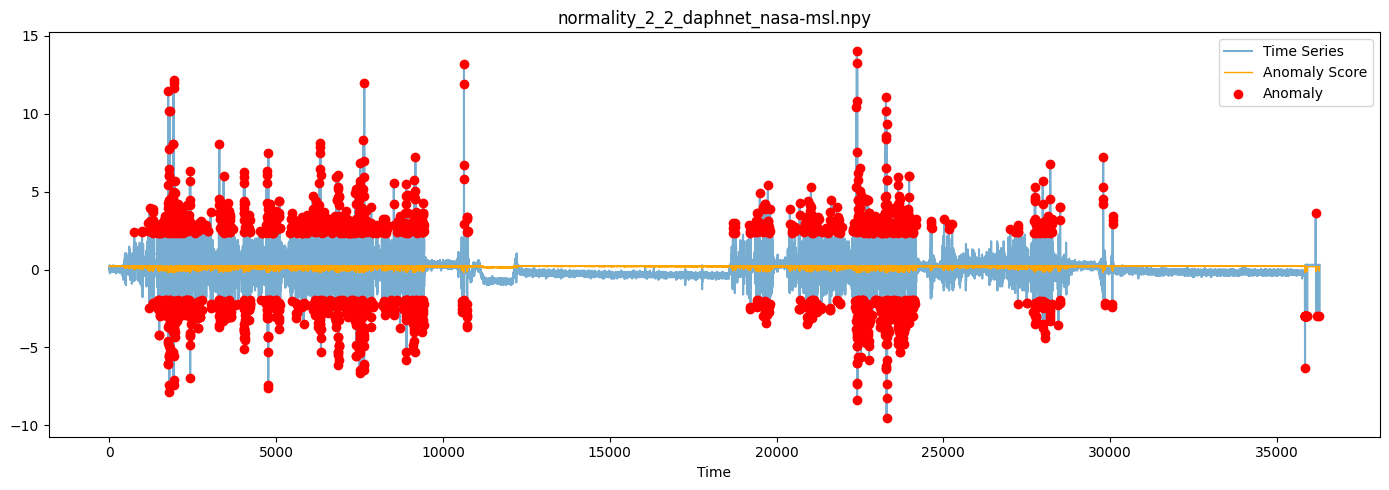

Processing: normality_2_3_genesis_nasa-msl.npy


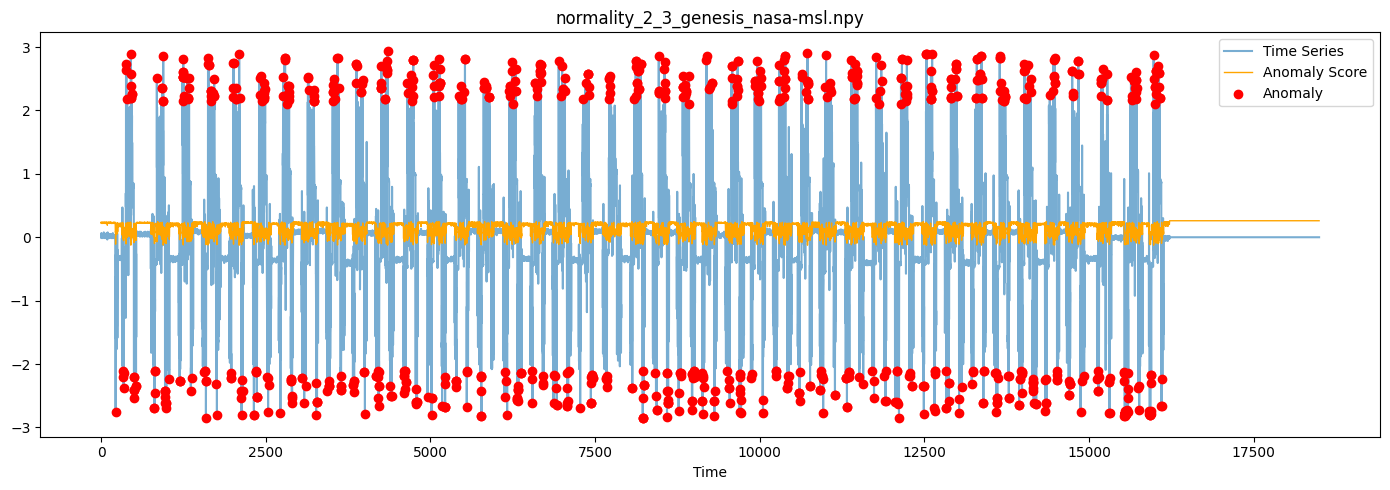

Processing: normality_3_1_daphnet_genesis_nasa-msl.npy


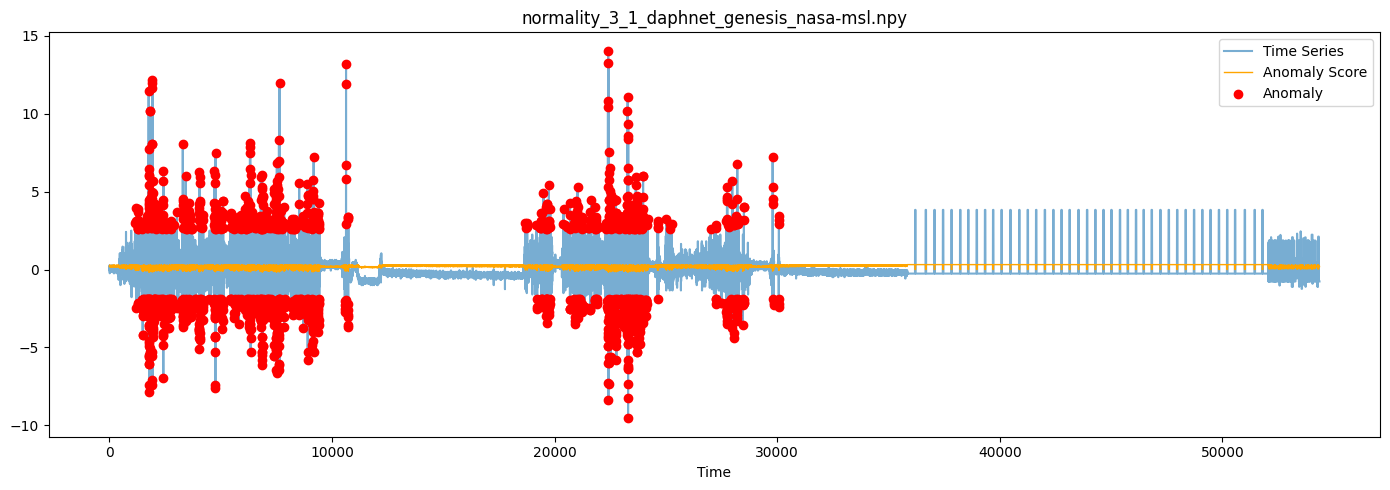

Processing: normality_3_2_genesis_nasa-msl_daphnet.npy


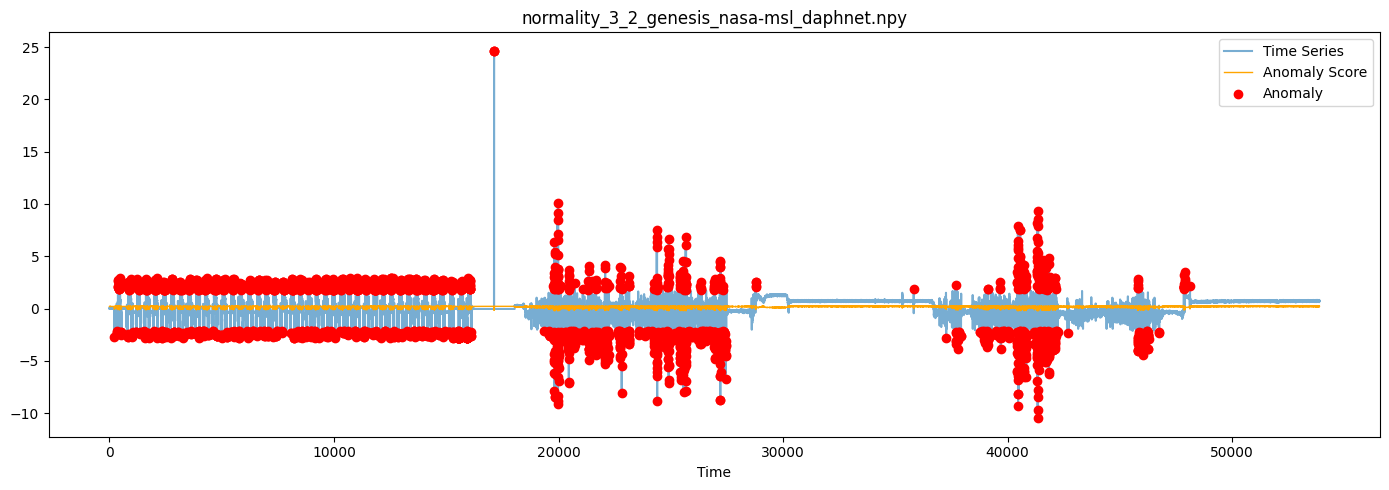

Processing: normality_3_3_nasa-msl_daphnet_genesis.npy


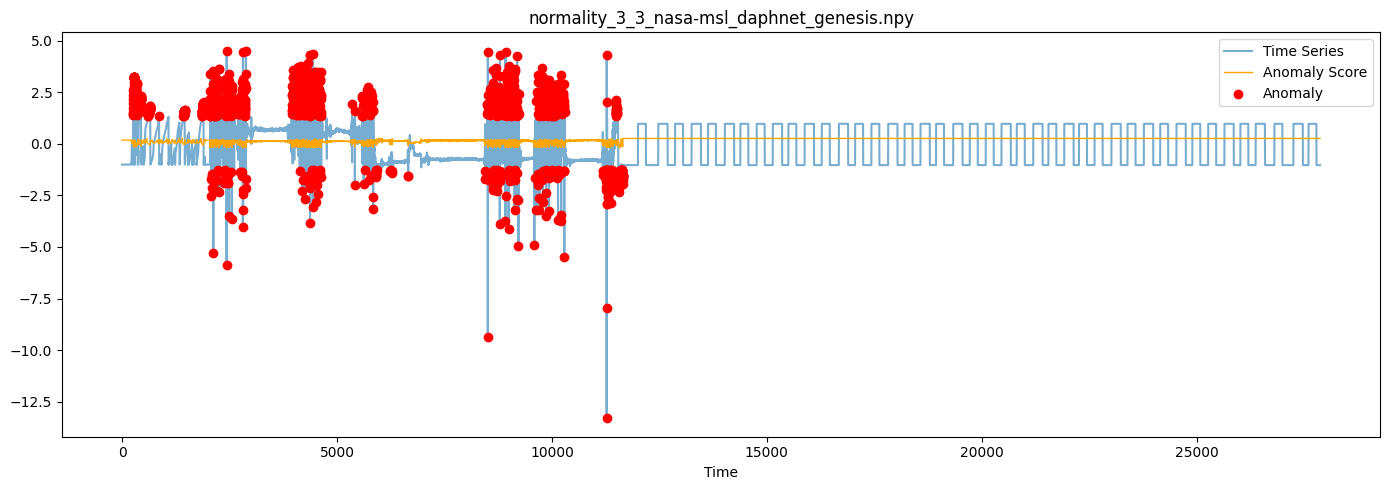


 Summary of All Offline Results:


,length,precision,recall,f1_score,auc
dataset,,,,,
normality_1_daphnet.npy,35840,0.000,0.000,0.000,0.551
normality_1_genesis.npy,16220,0.000,0.000,0.000,0.497
normality_1_nasa-msl.npy,3969,0.005,0.005,0.005,0.466
normality_2_1_daphnet_genesis.npy,25820,0.000,0.000,0.000,0.287
normality_2_2_daphnet_nasa-msl.npy,36279,0.023,0.023,0.023,0.267
normality_2_3_genesis_nasa-msl.npy,18492,0.000,0.000,0.000,0.038
normality_3_1_daphnet_genesis_nasa-msl.npy,54363,0.000,0.000,0.000,0.644
normality_3_2_genesis_nasa-msl_daphnet.npy,53887,0.000,0.000,0.000,0.137
normality_3_3_nasa-msl_daphnet_genesis.npy,27871,0.000,0.000,0.000,0.284


In [30]:
results = []

for filename in os.listdir(DATASET_PATH):
    if filename.endswith(".npy") and "_boundaries" not in filename:
        print(f"Processing: {filename}")
        data = load_dataset(filename).reshape(-1, 1)
        labels = generate_synthetic_labels(len(data), CONTAMINATION)

        preds, scores = run_isolation_forest(data, CONTAMINATION)
        precision, recall, f1 ,auc = evaluate(labels, preds)

        # Plot inline AND save
        plot_file = os.path.join(PLOTS_PATH, filename.replace(".npy", ".png"))
        plot_results(data, scores, preds, title=filename, save_path=plot_file)

        # # Print metrics
        # print(f"{filename}")
        # print(f"   Precision: {precision:.3f}")
        # print(f"   Recall   : {recall:.3f}")
        # print(f"   F1-Score : {f1:.3f}")
        # print("-" * 40)

        results.append({
            "dataset": filename,
            "length": len(data),
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1_score": round(f1, 3),
            "auc": round(auc, 3)
        })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="dataset")
results_df.set_index("dataset", inplace=True)

print("\n Summary of All Offline Results:")
display(results_df)

# Save to CSV as before
results_df.to_csv(RESULTS_CSV)


## Summary

We applied Isolation Forest to each dataset in an offline setting. Although we used synthetic labels (last 5% of data as anomalies), this step provides a baseline to compare against streaming and modified variants.

Next, we will evaluate a real-time method like SAND to see how it performs under streaming conditions.
